<a href="https://colab.research.google.com/github/ZhaoQii/IST597/blob/main/IST597_HW5_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up

In [ ]:
import tensorflow as tf
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
#tf.random.set_seed(1234)

In [ ]:
import sys
sys.path.insert(1,'/content/')
from data_utils import parse_imdb_sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


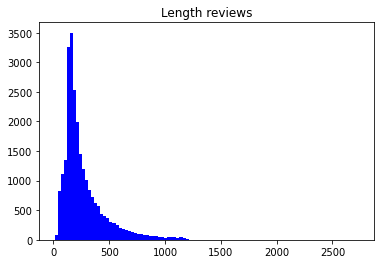

In [ ]:
length_reviews = pickle.load(open('/content/length_reviews.pkl', 'rb'))
pd.DataFrame(length_reviews, columns=['Length reviews']).hist(bins=100, color='blue');
plt.grid(False);

In [ ]:
# read data and split the training set to both training and validation sets
train_dataset_full = tf.data.TFRecordDataset('/content/train.tfrecords')
train_dataset_full = train_dataset_full.map(parse_imdb_sequence)
train_dataset = train_dataset_full.take(20000)
val_dataset = train_dataset_full.skip(20000)

In [ ]:
train_dataset = train_dataset.shuffle(buffer_size = 10000).padded_batch(512, padded_shapes=([None], [], []))
val_dataset = val_dataset.shuffle(buffer_size = 10000).padded_batch(512, padded_shapes=([None], [], []))

In [ ]:
# read test data
test_dataset = tf.data.TFRecordDataset('/content/test.tfrecords')
test_dataset = test_dataset.map(parse_imdb_sequence).shuffle(buffer_size=10000)
test_dataset = test_dataset.padded_batch(512, padded_shapes=([None],[],[]))

In [ ]:
# Read the word vocabulary
word2idx = pickle.load(open('/content/word2idx.pkl', 'rb'))

# Model

In [ ]:
class RNNModel(tf.keras.Model):
    def __init__(self, embedding_size=100, cell_size=64, dense_size=128, 
                 num_classes=2, vocabulary_size=None, rnn_cell='lstm',
                 device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation on and the checkpoint
            directory. Additionaly, you can also modify the default size of the 
            network.
            
            Args:
                embedding_size: the size of the word embedding.
                cell_size: RNN cell size.
                dense_size: the size of the dense layer.
                num_classes: the number of labels in the network.
                vocabulary_size: the size of the word vocabulary.
                rnn_cell: string, either 'lstm' or 'ugrnn'.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        '''
        super(RNNModel, self).__init__()
        
        # Weights initializer function
        w_initializer = tf.compat.v1.keras.initializers.glorot_uniform()
    
        # Biases initializer function
        b_initializer = tf.zeros_initializer()
        
        # Initialize weights for word embeddings 
        self.embeddings = tf.keras.layers.Embedding(vocabulary_size, embedding_size, 
                                                    embeddings_initializer=w_initializer)
        
        # Dense layer initialization
        self.dense_layer = tf.keras.layers.Dense(dense_size, activation=tf.nn.relu, 
                                                 kernel_initializer=w_initializer, 
                                                 bias_initializer=b_initializer)
        
        # Predictions layer initialization
        self.pred_layer = tf.keras.layers.Dense(num_classes, activation=None, 
                                                kernel_initializer=w_initializer, 
                                                bias_initializer=b_initializer)
        
        # Basic LSTM cell
        if rnn_cell=='lstm':
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(cell_size)
        # Else RNN cell
        else:
            self.rnn_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(cell_size)
            
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        
    def predict(self, X, seq_length, is_training):
        '''
        Predicts the probability of each class, based on the input sample.

        Args:
            X: 2D tensor of shape (batch_size, time_steps).
            seq_length: the length of each sequence in the batch.
            is_training: Boolean. Either the network is predicting in
                         training mode or not.
        '''
        
        # Get the number of samples within a batch
        num_samples = tf.shape(X)[0]

        # Initialize LSTM cell state with zeros
        state = self.rnn_cell.zero_state(num_samples, dtype=tf.float32)
        
        # Get the embedding of each word in the sequence
        embedded_words = self.embeddings(X)
        
        # Unstack the embeddings
        unstacked_embeddings = tf.unstack(embedded_words, axis=1)
        
        # Iterate through each timestep and append the predictions
        outputs = []
        for input_step in unstacked_embeddings:
            output, state = self.rnn_cell(input_step, state)
            outputs.append(output)
            
        # Stack outputs to (batch_size, time_steps, cell_size)
        outputs = tf.stack(outputs, axis=1)
        
        # Extract the output of the last time step, of each sample
        idxs_last_output = tf.stack([tf.range(num_samples), 
                                     tf.cast(seq_length-1, tf.int32)], axis=1)
        final_output = tf.gather_nd(outputs, idxs_last_output)
        
        # Add dropout for regularization
        #dropped_output = tf.compat.v1.layers.Dropout(final_output, rate=0.3, training=is_training)
        
        # Pass the last cell state through a dense layer (ReLU activation)
        dense = self.dense_layer(final_output)
        
        # Compute the unnormalized log probabilities
        logits = self.pred_layer(dense)
        return logits
    
    def loss_fn(self, X, y, seq_length, is_training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(X, seq_length, is_training)
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=preds)
        return loss
    
    def grads_fn(self, X, y, seq_length, is_training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(X, y, seq_length, is_training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,1)))
            dummy_length = tf.constant(1, shape=(1,))
            dummy_pred = self.predict(dummy_input, dummy_length, False)
            # Restore the variables of the model
            saver = tf.compat.v1.train.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.compat.v1.train.Saver(self.variables).save(save_path=self.checkpoint_directory, 
                                       global_step=global_step)   
        
    def fit(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the accuracy on the eval 
                                       dataset does not increase after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best_acc. This variable will store the highest accuracy
        # on the eval dataset.
        best_acc = 0
        
        # Initialize classes to update the mean accuracy of train and eval
        train_acc = tf.keras.metrics.Accuracy('train_acc')
        eval_acc = tf.keras.metrics.Accuracy('eval_acc')
        
        # Initialize dictionary to store the accuracy history
        self.history = {}
        self.history['train_acc'] = []
        self.history['eval_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                for step, (X, y, seq_length) in enumerate(training_data):
                    grads = self.grads_fn(X, y, seq_length, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Check accuracy train dataset
                for step, (X, y, seq_length) in enumerate(training_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    train_acc(preds, y)
                self.history['train_acc'].append(train_acc.result().numpy())
                # Reset metrics
                train_acc.reset_states()

                # Check accuracy eval dataset
                for step, (X, y, seq_length) in enumerate(eval_data):
                    logits = self.predict(X, seq_length, False)
                    preds = tf.argmax(logits, axis=1)
                    eval_acc(preds, y)
                self.history['eval_acc'].append(eval_acc.result().numpy())
                # Reset metrics
                eval_acc.reset_states()
                
                # Print train and eval accuracy
                if (i==0) | ((i+1)%verbose==0):
                    print('Train accuracy at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    print('Eval accuracy at epoch %d: ' %(i+1), self.history['eval_acc'][-1])

                # Check for early stopping
                if self.history['eval_acc'][-1]>best_acc:
                    best_acc = self.history['eval_acc'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break  

# Train

In [ ]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/ImdbRNN/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-2)

# Instantiate model. This doesn't initialize the variables yet.
lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                      checkpoint_directory=checkpoint_directory)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.


In [ ]:
# Train model
import time
start_time = time.time()
lstm_model.fit(train_dataset, val_dataset, optimizer, num_epochs=5, 
                early_stopping_rounds=5, verbose=1, train_from_scratch=True)
end_time = time.time()
used_time = end_time - start_time

/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.79165
Eval accuracy at epoch 1:  0.7548
Train accuracy at epoch 2:  0.8637
Eval accuracy at epoch 2:  0.7672
Train accuracy at epoch 3:  0.9681
Eval accuracy at epoch 3:  0.8378
Train accuracy at epoch 4:  0.95595
Eval accuracy at epoch 4:  0.7984
Train accuracy at epoch 5:  0.9926
Eval accuracy at epoch 5:  0.843


In [ ]:
used_time

448.60560369491577

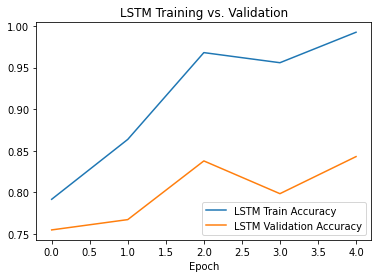

In [ ]:
plt.plot(range(len(lstm_model.history['train_acc'])), lstm_model.history['train_acc'], 
         label='LSTM Train Accuracy')
plt.plot(range(len(lstm_model.history['eval_acc'])), lstm_model.history['eval_acc'], 
         label='LSTM Validation Accuracy')
plt.title('LSTM Training vs. Validation')
plt.xlabel('Epoch')
plt.legend()

# Test on new sample

In [ ]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re

In [ ]:
def process_new_review(review):
    '''Function to process a new review.
       Args:
           review: original text review, string.
       Returns:
           indexed_review: sequence of integers, words correspondence 
                           from word2idx.
           seq_length: the length of the review.
    '''
    indexed_review = re.sub(r'<[^>]+>', ' ', review)
    indexed_review = word_tokenize(indexed_review)
    indexed_review = [word2idx[word] if word in list(word2idx.keys()) else 
                      word2idx['Unknown_token'] for word in indexed_review]
    indexed_review = indexed_review + [word2idx['End_token']]
    seq_length = len(indexed_review)    
    return indexed_review, seq_length

In [ ]:
test_acc = tf.keras.metrics.Accuracy('test_acc')
test_history = {}
test_history['test_acc'] = []

with tf.device(device):
    for step, (X, y, seq_length) in enumerate(test_dataset):
        #indexed_review, seq_length = process_new_review(original_review)
        #indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
        #seq_length = tf.reshape(tf.constant(seq_length), (1,))
        logits = lstm_model.predict(X, seq_length, False)
        preds = tf.argmax(logits, axis=1)
        test_acc(preds, y)
    test_history['test_acc'].append(test_acc.result().numpy())
    # test_acc.reset_states()

In [ ]:
test_history['test_acc'][0]

0.68224

# Multiple Trails

In [ ]:
import numpy as np
num_trials = 5

test_accuracy = np.zeros([num_trials, 2]) # 0 for before 1 for after
used_time = np.zeros([num_trials, 2])

In [ ]:
for t in range(num_trials):
  print(t)

  # Specify the path where you want to save/restore the trained variables.
  checkpoint_directory = 'models_checkpoints/ImdbRNN/'

  # Use the GPU if available.
  device = 'gpu:0'

  # Define optimizer.
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

  # Instantiate model. This doesn't initialize the variables yet.
  lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                        checkpoint_directory=checkpoint_directory)

  start_time = time.time()
  lstm_model.fit(train_dataset, val_dataset, optimizer, num_epochs=5, 
                  early_stopping_rounds=5, verbose=1, train_from_scratch=True)
  end_time = time.time()
  used_time[t, 0] = end_time - start_time

  test_acc = tf.keras.metrics.Accuracy('test_acc')
  test_history = {}
  test_history['test_acc'] = []

  with tf.device(device):
      for step, (X, y, seq_length) in enumerate(test_dataset):
          #indexed_review, seq_length = process_new_review(original_review)
          #indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
          #seq_length = tf.reshape(tf.constant(seq_length), (1,))
          logits = lstm_model.predict(X, seq_length, False)
          preds = tf.argmax(logits, axis=1)
          test_acc(preds, y)
      test_history['test_acc'].append(test_acc.result().numpy())
      # test_acc.reset_states()
  test_accuracy[t, 0] = test_history['test_acc'][0]

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.5905
Eval accuracy at epoch 1:  0.5662
Train accuracy at epoch 2:  0.7685
Eval accuracy at epoch 2:  0.7288
Train accuracy at epoch 3:  0.8586
Eval accuracy at epoch 3:  0.8362
Train accuracy at epoch 4:  0.9037
Eval accuracy at epoch 4:  0.8616
Train accuracy at epoch 5:  0.93505
Eval accuracy at epoch 5:  0.8816
1
Train accuracy at epoch 1:  0.68495
Eval accuracy at epoch 1:  0.654
Train accuracy at epoch 2:  0.77095
Eval accuracy at epoch 2:  0.7372
Train accuracy at epoch 3:  0.84815
Eval accuracy at epoch 3:  0.8206
Train accuracy at epoch 4:  0.91625
Eval accuracy at epoch 4:  0.8756
Train accuracy at epoch 5:  0.9365
Eval accuracy at epoch 5:  0.8854
2
Train accuracy at epoch 1:  0.72895
Eval accuracy at epoch 1:  0.695
Train accuracy at epoch 2:  0.8082
Eval accuracy at epoch 2:  0.7906
Train accuracy at epoch 3:  0.83775
Eval accuracy at epoch 3:  0.809
Train accuracy at epoch 4:  0.9111
Eval accuracy at epoch 4:  0.8606
Train accuracy at epoch 5:

In [ ]:
used_time

array([[451.92672443,   0.        ],
       [463.65196347,   0.        ],
       [437.50462842,   0.        ],
       [434.91604972,   0.        ],
       [433.33117485,   0.        ]])

In [ ]:
test_accuracy

array([[0.85887998, 0.        ],
       [0.86075997, 0.        ],
       [0.86607999, 0.        ],
       [0.84328002, 0.        ],
       [0.86900002, 0.        ]])

In [ ]:
test_accuracy = np.zeros([num_trials, 2]) # 0 for before 1 for after
used_time = np.zeros([num_trials, 2])

In [ ]:
for t in range(num_trials):
  print(t)

  # Specify the path where you want to save/restore the trained variables.
  checkpoint_directory = 'models_checkpoints/ImdbRNN/'

  # Use the GPU if available.
  device = 'gpu:0'

  # Define optimizer.
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-2)

  # Instantiate model. This doesn't initialize the variables yet.
  lstm_model = RNNModel(vocabulary_size=len(word2idx), device=device, 
                        checkpoint_directory=checkpoint_directory)

  start_time = time.time()
  lstm_model.fit(train_dataset, val_dataset, optimizer, num_epochs=5, 
                  early_stopping_rounds=5, verbose=1, train_from_scratch=True)
  end_time = time.time()
  used_time[t, 1] = end_time - start_time

  test_acc = tf.keras.metrics.Accuracy('test_acc')
  test_history = {}
  test_history['test_acc'] = []

  with tf.device(device):
      for step, (X, y, seq_length) in enumerate(test_dataset):
          #indexed_review, seq_length = process_new_review(original_review)
          #indexed_review = tf.reshape(tf.constant(indexed_review), (1,-1))
          #seq_length = tf.reshape(tf.constant(seq_length), (1,))
          logits = lstm_model.predict(X, seq_length, False)
          preds = tf.argmax(logits, axis=1)
          test_acc(preds, y)
      test_history['test_acc'].append(test_acc.result().numpy())
      # test_acc.reset_states()
  test_accuracy[t, 1] = test_history['test_acc'][0]

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:756: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + h_depth, 4 * self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:760: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


Train accuracy at epoch 1:  0.8307
Eval accuracy at epoch 1:  0.7456
Train accuracy at epoch 2:  0.88505
Eval accuracy at epoch 2:  0.7786
Train accuracy at epoch 3:  0.96705
Eval accuracy at epoch 3:  0.8572
Train accuracy at epoch 4:  0.98755
Eval accuracy at epoch 4:  0.829
Train accuracy at epoch 5:  0.9883
Eval accuracy at epoch 5:  0.831
1
Train accuracy at epoch 1:  0.83845
Eval accuracy at epoch 1:  0.7642
Train accuracy at epoch 2:  0.93615
Eval accuracy at epoch 2:  0.823
Train accuracy at epoch 3:  0.9733
Eval accuracy at epoch 3:  0.8524
Train accuracy at epoch 4:  0.9917
Eval accuracy at epoch 4:  0.8308
Train accuracy at epoch 5:  0.9811
Eval accuracy at epoch 5:  0.8088
2
Train accuracy at epoch 1:  0.7984
Eval accuracy at epoch 1:  0.732
Train accuracy at epoch 2:  0.84695
Eval accuracy at epoch 2:  0.7478
Train accuracy at epoch 3:  0.52955
Eval accuracy at epoch 3:  0.5326
Train accuracy at epoch 4:  0.9556
Eval accuracy at epoch 4:  0.8582
Train accuracy at epoch 5: 

In [ ]:
end_time - start_time

448.1743805408478

In [ ]:
used_time

array([[  0.        , 454.32205415],
       [  0.        , 443.81040764],
       [  0.        , 479.44933534],
       [  0.        , 437.68436337],
       [  0.        , 435.73716998]])

In [ ]:
test_accuracy

array([[0.        , 0.81735998],
       [0.        , 0.79579997],
       [0.        , 0.82936001],
       [0.        , 0.83112001],
       [0.        , 0.81283998]])